In [1]:
# import library
from library import *

# filter the warnings for clarity
import warnings
warnings.filterwarnings("ignore")

In this notebook, we show how to reconstruct the ECL benchmark dataset. This dataset combines three existing data sources: the Edgar corpus, Compustat and the Lopucki bankruptcy research database. Due to the paid access required for Compustat, we are unable to share the complete benchmark dataset. However, here we provide the necessary code to allow you to reconstruct the dataset.

In the master CSV-file (see the repository readme), each row corresponds to a 10K filing uniquely identified through (1) the company id (cik, gvkey, or company name) and (2) the fiscal year-end date (period_of_report). Each 10K filing can be matched (1) with a document from the Edgar corpus through the filename variable and (2) with an entry from Compustat through the gvkey and datadate variables. See the repository readme for access to the Edgar corpus and Compustat.

In [2]:
# read the master CSV-file
dataset = pd.read_csv('ECL.csv', index_col=0)
dataset.sample(5)

,cik,company,period_of_report,gvkey,datadate,filename,can_label,qualified,label,bankruptcy_prediction_split,bankruptcy_date_1,bankruptcy_date_2,bankruptcy_date_3,filing_date
69844,731766.0,UNITEDHEALTH GROUP INC,2015-12-31,10903.0,31/12/2015,/2015/731766_10K_2015_0000731766-16-000058.json,True,Yes,False,test,NaN,NaN,NaN,2016-02-09
73154,755199.0,TRANSMONTAIGNE INC,2000-06-30,11747.0,30/06/2000,/2000/755199_10K_2000_0000927356-00-001824.json,True,Yes,False,train,NaN,NaN,NaN,2000-09-21
163536,1004702.0,OCEANFIRST FINANCIAL CORP,2007-12-31,63232.0,31/12/2007,/2007/1004702_10K_2007_0001193125-08-058535.json,True,Yes,False,train,NaN,NaN,NaN,2008-03-17
148081,935724.0,PMI GROUP INC,2005-12-31,31707.0,31/12/2005,/2005/935724_10K_2005_0001193125-06-053826.json,True,Yes,False,train,2011-11-23,NaN,NaN,2006-03-14
216934,1408198.0,MSCI INC.,2010-11-30,178507.0,30/11/2010,/2010/1408198_10K_2010_0001193125-11-017728.json,True,Yes,False,train,NaN,NaN,NaN,2011-01-31


#### Match with Compustat through API

When working with a local copy of the Compustat data, the compustat_wrds() function can be used to match these records with the master CSV-file. This function:
- reads the Compustat file from the API (we use the "comp_na_annual_all" library and the "funda" table)
- filters the Compustat file on screening variables (```datafmt```, ```indfmt```, ```consol``` and ```popsrc```)
- matches the datasets on the ```gvkey``` and ```datadata``` variables

In [ ]:
# load data through API
username = ''
db = wrds.Connection(wrds_username=username)

# select desired variables
variables = 'ch, dt, act'

# match datasets
dataset = compustat_wrds(variables, dataset, db)

In [5]:
# inspect
dataset.sample(5)[['cik', 'company', 'period_of_report', 'ch', 'dt', 'act']]

,cik,company,period_of_report,ch,dt,act
106764,1002517.0,SCANSOFT INC,2002-12-31,18.853,0.000,40.429
82836,1672013.0,ACUSHNET HOLDINGS CORP.,2019-12-31,34.184,393.682,742.818
168089,1403528.0,"OAKTREE CAPITAL GROUP, LLC",2013-12-31,NaN,579.464,NaN
147766,1174922.0,WYNN RESORTS LTD,2014-12-31,2182.164,7345.262,2782.331
62673,1339256.0,"HOT MAMAS FOODS, INC.",2013-12-31,0.150,2.331,3.827


#### Match with local Compustat file

When working with a local copy of the Compustat data, the compustat_local() function can be used to match these records with the master CSV-file. This function:
- reads the local Compustat file
- filters the Compustat file on screening variables (```datafmt```, ```indfmt```, ```consol``` and ```popsrc```)
- matches the datasets on the ```gvkey``` and ```datadata``` variables

In [3]:
# load data and match datasets
path = './data/CompuStat/data.csv'
dataset = compustat_local(path, dataset, update=False)

Dropped 115373 rows from CompuStat based on screening variables
0 records in the dataset do not have an accompanying CompuStat record.


In [4]:
# inspect
dataset.sample(5)[['cik', 'company', 'period_of_report', 'ch', 'dt', 'act']]

,cik,company,period_of_report,ch,dt,act
57284,842162.0,LEAR CORP /DE/,2003-12-31,169.300,2061.200,3375.400
59489,846931.0,NEW HAMPSHIRE THRIFT BANCSHARES INC,2009-12-31,20.339,NaN,NaN
153249,1297989.0,"EXLSERVICE HOLDINGS, INC.",2018-12-31,95.881,285.202,499.935
84348,896159.0,ACE LTD,1996-09-30,53.374,NaN,NaN
37352,98827.0,TOWER PROPERTIES CO,2001-12-31,3.828,57.280,NaN


#### Match with Edgar corpus

The ECL data can be matched with a record in the Edgar corpus through the ```filename``` variable.

In [8]:
# get filename for example company
corpus_path = './data'
file = dataset.loc[dataset['cik'] == 1318605, 'filename'].iloc[-1]

# read
with open(corpus_path + file) as fp:
    text = json.load(fp)

In [9]:
# inspect
print(text['item_7'][802:1700] + '...')

Our mission is to accelerate the world’s transition to sustainable energy. We design, develop, manufacture, lease and sell high-performance fully electric vehicles, solar energy generation systems and energy storage products. We also offer maintenance, installation, operation, financial and other services related to our products. Additionally, we are increasingly focused on products and services based on artificial intelligence, robotics and automation.
In 2022, we produced 1,369,611 consumer vehicles and delivered 1,313,851 consumer vehicles, despite ongoing supply chain and logistics challenges and factory shutdowns. We are currently focused on increasing vehicle production, capacity and delivery capabilities, improving and developing battery technologies, improving our FSD capabilities, increasing the affordability and efficiency of our vehicles, bringing new products to market and ...


### Example Analysis

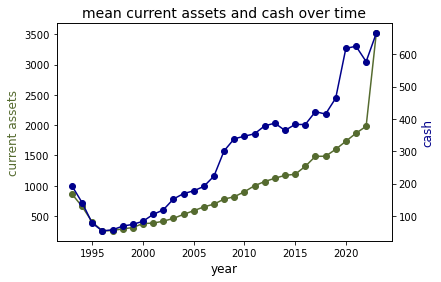

In [13]:
# plot evolution of current assets over time
fig,ax = plt.subplots()
dataset['year'] = pd.to_datetime(dataset['period_of_report']).dt.year
ax.plot(dataset[['year', 'act']].groupby('year').mean(), color="darkolivegreen", marker="o")
ax.set_xlabel("year", fontsize = 12)
ax.set_ylabel("current assets", color="darkolivegreen", fontsize=12)
ax.set_title('mean current assets and cash over time', fontsize=14)

# plot evolution of cash over time
ax2=ax.twinx()
ax2.plot(dataset[['year', 'ch']].groupby('year').mean(),color="darkblue",marker="o")
ax2.set_ylabel("cash",color="darkblue",fontsize=12)
plt.show()